In [3]:
import requests

# Fetch Binance trading pairs
url = "https://api.binance.com/api/v3/exchangeInfo"
response = requests.get(url)
data = response.json()

# Extract all symbols
symbols = [s['symbol'] for s in data['symbols']]

# Find coins that have both USDT and BTC pairs
usdt_pairs = {s for s in symbols if s.endswith("USDT")}
btc_pairs = {s.replace("BTC", "USDT") for s in symbols if s.endswith("BTC")}

# Get the USDT trading pairs of common coins
common_usdt_pairs = usdt_pairs & btc_pairs

# Display results
print("USDT Pairs for Coins that Have Both USDT & BTC Pairs:")
print(sorted(common_usdt_pairs))


USDT Pairs for Coins that Have Both USDT & BTC Pairs:
['1INCHUSDT', 'AAVEUSDT', 'ACAUSDT', 'ACEUSDT', 'ACHUSDT', 'ACMUSDT', 'ADAUSDT', 'ADXUSDT', 'AERGOUSDT', 'AEVOUSDT', 'AGIXUSDT', 'AGLDUSDT', 'AIONUSDT', 'AIUSDT', 'AKROUSDT', 'ALCXUSDT', 'ALGOUSDT', 'ALICEUSDT', 'ALPACAUSDT', 'ALPHAUSDT', 'ALPINEUSDT', 'ALTUSDT', 'AMBUSDT', 'AMPUSDT', 'ANCUSDT', 'ANKRUSDT', 'ANTUSDT', 'ANYUSDT', 'APEUSDT', 'API3USDT', 'APTUSDT', 'ARBUSDT', 'ARDRUSDT', 'ARKMUSDT', 'ARKUSDT', 'ARPAUSDT', 'ARUSDT', 'ASRUSDT', 'ASTRUSDT', 'ASTUSDT', 'ATAUSDT', 'ATMUSDT', 'ATOMUSDT', 'AUCTIONUSDT', 'AUDIOUSDT', 'AUTOUSDT', 'AVAUSDT', 'AVAXUSDT', 'AXLUSDT', 'AXSUSDT', 'BADGERUSDT', 'BAKEUSDT', 'BALUSDT', 'BANANAUSDT', 'BANDUSDT', 'BARUSDT', 'BATUSDT', 'BBUSDT', 'BCCUSDT', 'BCHABCUSDT', 'BCHSVUSDT', 'BCHUSDT', 'BEAMUSDT', 'BELUSDT', 'BERAUSDT', 'BETAUSDT', 'BICOUSDT', 'BLURUSDT', 'BLZUSDT', 'BNBUSDT', 'BNTUSDT', 'BNXUSDT', 'BOMEUSDT', 'BONDUSDT', 'BTGUSDT', 'BTSUSDT', 'BTTUSDT', 'BZRXUSDT', 'C98USDT', 'CAKEUSDT', 'CELOUSDT

In [ ]:
import numpy as np
import pandas as pd
import ccxt
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
import talib
import requests
from gym import spaces, Env
def dataCapture(symbol,interval):
    url = "https://api.binance.com/api/v3/klines"
    params = {
        'symbol': symbol,  # The trading pair
        'interval': interval,     # 1-minute candlesticks
        'startTime':'1739970662',
        'endTime':'1739995866'
    }

    response = requests.get(url, params=params)
    data = response.json()

    if response.status_code == 200:
        data = pd.DataFrame(
            data,
            columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 
                        'close_time', 'quote_asset_volume', 'number_of_trades', 
                        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
        )
        data = data[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
        #data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
        # data.set_index('timestamp', inplace=True)
        data = data.astype(float)
        return data
    else:
        print(f"Error: {response.status_code}, {response.text}")


import pandas as pd

def fetch_data(pairs, interval='1s'):
    """
    Fetches data for a list of trading pairs and merges them into a single DataFrame.
    
    :param pairs: List of trading pairs (e.g., ['BTCUSDT', 'ETHUSDT'])
    :param interval: Time interval for fetching data (default is '1s')
    :return: Merged DataFrame containing timestamp and closing prices of the pairs.
    """
    dfs = []
    for pair in pairs:
        df = pd.DataFrame(dataCapture(pair, interval)[['timestamp', 'close']])
        df.rename(columns={'close': f'{pair}_close'}, inplace=True)
        dfs.append(df)
    
    # Merge all DataFrames on 'timestamp'
    merged_df = dfs[0]
    print(merged_df)
    for df in dfs[1:]:
        merged_df = merged_df.merge(df, on='timestamp', how='outer')
    
    # Sort values by timestamp and drop NaN values
    merged_df.sort_values('timestamp', inplace=True)
    merged_df.reset_index(drop=True, inplace=True)
    merged_df.dropna(inplace=True)
    
    return merged_df

# Example usage
pairs = common_usdt_pairs
merged_data = fetch_data(pairs)
print(merged_data)

In [16]:
import pandas as pd
merged_df = merged_data
# Compute BTC's percentage change
merged_df['BTC_pct_change'] = merged_df['BTC_close'].pct_change()

# Compute percentage change for all other assets
for col in merged_df.columns:
    if 'close' in col and col != 'BTC_close':
        merged_df[f'{col}_pct_change'] = merged_df[col].pct_change()

# Drop NaN values caused by `pct_change()`
merged_df.dropna(inplace=True)

# Display the processed DataFrame
print(merged_df.head())


KeyError: 'BTC_close'

Prepare Training & Test Sets and Standardize the Data<br>

In [134]:
import numpy as np

# Categorize BTC price movement (Up, Down, Neutral)
conditions = [
    (merged_df['BTC_pct_change'] > 0.005),  # BTC up more than 0.5%
    (merged_df['BTC_pct_change'] < -0.005), # BTC down more than 0.5%
]
choices = ['BTC_UP', 'BTC_DOWN']

# Use numpy.select instead of pd.np.select
merged_df['BTC_trend'] = np.select(conditions, choices, default='BTC_NEUTRAL')

# Compute the average movement of other assets per BTC trend
pattern_analysis = merged_df.groupby('BTC_trend').mean()

# Display insights
print(pattern_analysis)

                timestamp     BTC_close    ETH_close   SOL_close  XRP_close  \
BTC_trend                                                                     
BTC_NEUTRAL  1.739993e+12  95976.930471  2714.808556  169.669037   2.666591   

              LTC_close   BNB_close  DOGE_close  TRUMP_close  BTC_pct_change  \
BTC_trend                                                                      
BTC_NEUTRAL  134.976449  652.068245     0.25224     16.88329   -7.570198e-09   

             ETH_close_pct_change  SOL_close_pct_change  XRP_close_pct_change  \
BTC_trend                                                                       
BTC_NEUTRAL             -0.000002             -0.000008              0.000002   

             LTC_close_pct_change  BNB_close_pct_change  \
BTC_trend                                                 
BTC_NEUTRAL             -0.000001             -0.000001   

             DOGE_close_pct_change  TRUMP_close_pct_change  
BTC_trend                             

In [135]:
# Compute correlation matrix
correlation_matrix = merged_df.filter(like='_pct_change').corr()

# Display correlations with BTC
btc_correlations = correlation_matrix['BTC_pct_change'].sort_values(ascending=False)
print(btc_correlations)


BTC_pct_change            1.000000
DOGE_close_pct_change     0.698896
ETH_close_pct_change      0.676462
XRP_close_pct_change      0.572315
SOL_close_pct_change      0.528754
BNB_close_pct_change      0.517080
LTC_close_pct_change      0.427123
TRUMP_close_pct_change    0.253096
Name: BTC_pct_change, dtype: float64


Best Lag for Each Asset:
ETH_close_pct_change      0
SOL_close_pct_change      0
XRP_close_pct_change      0
LTC_close_pct_change      0
BNB_close_pct_change      0
DOGE_close_pct_change     0
TRUMP_close_pct_change    0
dtype: int64


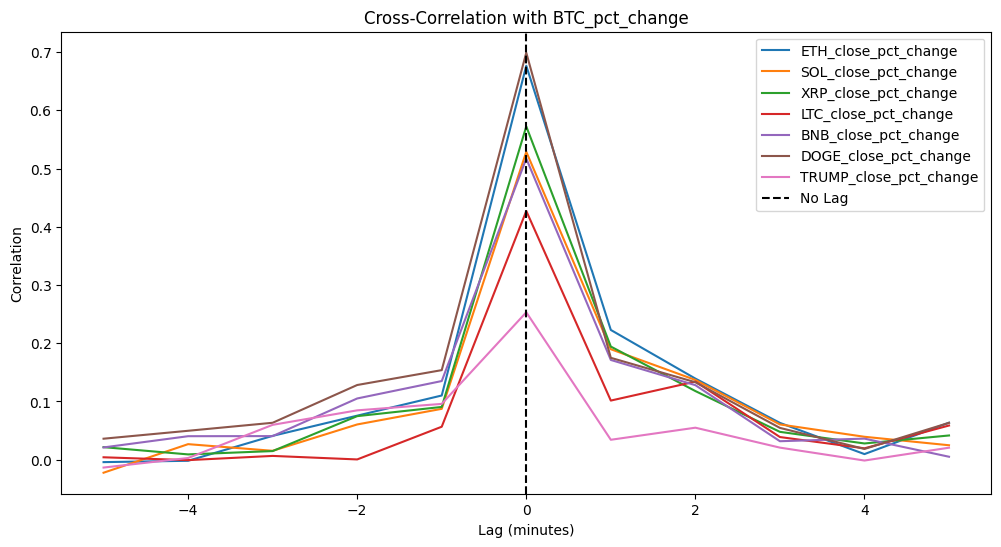

In [140]:
import numpy as np
import pandas as pd

# Define function to compute cross-correlation with lags
def cross_correlation(df, base_col, target_col, max_lag=10):
    lags = range(-max_lag, max_lag + 1)  # Test both positive and negative lags
    correlations = {}

    for lag in lags:
        shifted_df = df[[base_col, target_col]].dropna()
        shifted_df[target_col] = shifted_df[target_col].shift(lag)  # Apply lag
        
        correlation = shifted_df.corr().iloc[0, 1]  # Get correlation between base_col and target_col
        correlations[lag] = correlation
    
    return pd.Series(correlations)

# Compute cross-correlation for each asset vs BTC
max_lag = 5  # Test from -10 to +10 minutes
cross_corr_results = {}

for col in merged_df.columns:
    if col.endswith("_pct_change") and col != "BTC_pct_change":
        cross_corr_results[col] = cross_correlation(merged_df, "BTC_pct_change", col, max_lag)
# Convert to DataFrame for analysis
cross_corr_df = pd.DataFrame(cross_corr_results)

# Print the highest correlation lag for each asset
best_lags = cross_corr_df.idxmax()
print("Best Lag for Each Asset:")
print(best_lags)

# Plot cross-correlation curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for col in cross_corr_df.columns:
    plt.plot(cross_corr_df.index, cross_corr_df[col], label=col)

plt.axvline(0, color='black', linestyle='--', label="No Lag")
plt.legend()
plt.title("Cross-Correlation with BTC_pct_change")
plt.xlabel("Lag (minutes)")
plt.ylabel("Correlation")
plt.show()


                    Asset  Cluster
0          BTC_pct_change        0
1    ETH_close_pct_change        0
2    SOL_close_pct_change        0
3    XRP_close_pct_change        0
4    LTC_close_pct_change        1
5    BNB_close_pct_change        2
6   DOGE_close_pct_change        0
7  TRUMP_close_pct_change        0


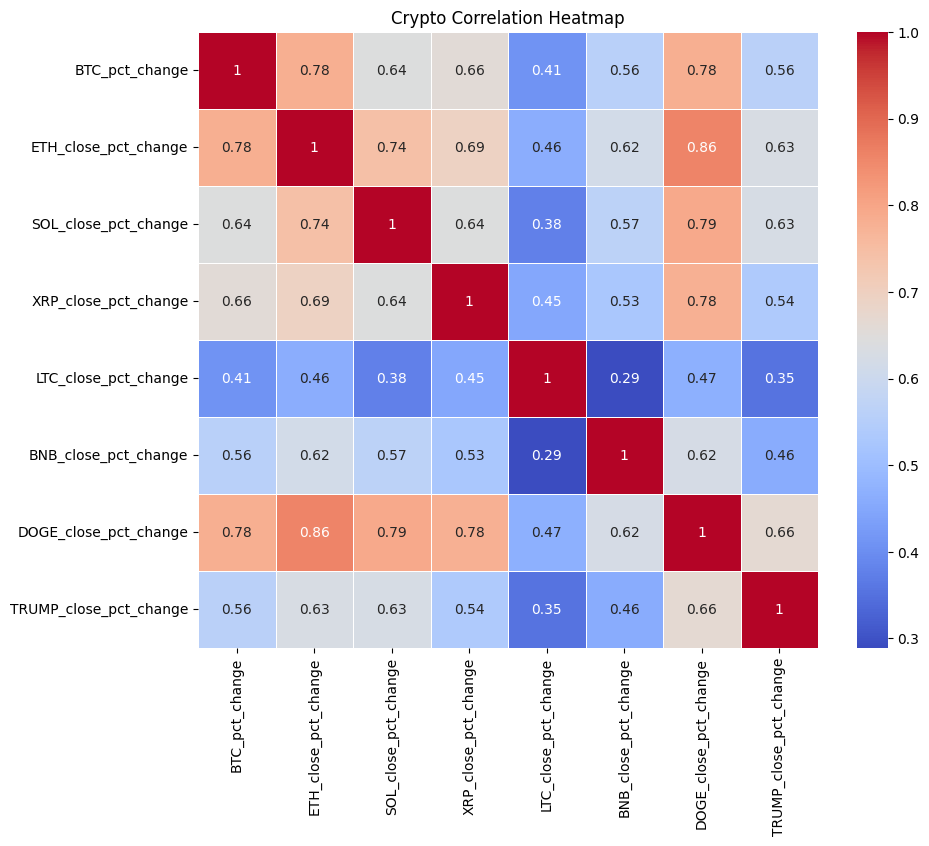

In [34]:
from sklearn.cluster import KMeans
import seaborn as sns

# Extract correlation matrix (excluding BTC itself)
correlation_matrix = merged_df.filter(like="_pct_change").corr()

# Use KMeans Clustering
n_clusters = 3  # Adjust based on dataset
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(correlation_matrix)

# Assign clusters to assets
cluster_df = pd.DataFrame({"Asset": correlation_matrix.index, "Cluster": cluster_labels})
print(cluster_df)

# Plot heatmap of correlation matrix with clustering
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Crypto Correlation Heatmap")
plt.show()


                        Reaction_BTC_Up  Reaction_BTC_Down
BTC_pct_change                 0.000300          -0.000315
ETH_close_pct_change           0.000422          -0.000449
SOL_close_pct_change           0.000596          -0.000647
XRP_close_pct_change           0.000623          -0.000598
LTC_close_pct_change           0.000537          -0.000541
BNB_close_pct_change           0.000361          -0.000374
DOGE_close_pct_change          0.000513          -0.000559
TRUMP_close_pct_change         0.000710          -0.000733


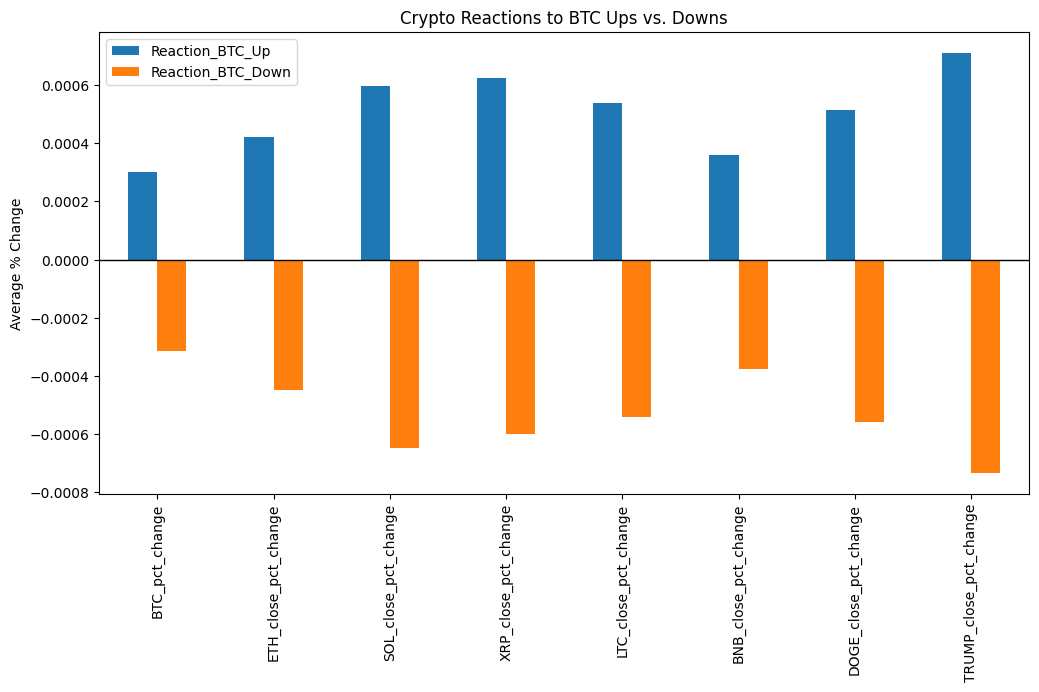

In [35]:
# Separate BTC up vs. down days
up_days = merged_df[merged_df["BTC_pct_change"] > 0]
down_days = merged_df[merged_df["BTC_pct_change"] < 0]

# Compute mean reactions for each asset
reaction_up = up_days.filter(like="_pct_change").mean()
reaction_down = down_days.filter(like="_pct_change").mean()

# Compare responses
asymmetric_response = pd.DataFrame({"Reaction_BTC_Up": reaction_up, "Reaction_BTC_Down": reaction_down})
print(asymmetric_response)

# Plot reactions
asymmetric_response.plot(kind="bar", figsize=(12, 6), title="Crypto Reactions to BTC Ups vs. Downs")
plt.axhline(0, color="black", linewidth=1)
plt.ylabel("Average % Change")
plt.show()


In [103]:
import numpy as np
import pandas as pd
import ccxt
from sklearn.preprocessing import StandardScaler
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
import talib
import requests
from gym import spaces, Env
def dataCapture(symbol,interval):
    url = "https://api.binance.com/api/v3/klines"
    params = {
        'symbol': symbol,  # The trading pair
        'interval': interval,     # 1-minute candlesticks
        'limit': 2000        # Number of data points to fetch
    }

    response = requests.get(url, params=params)
    data = response.json()

    if response.status_code == 200:
        data = pd.DataFrame(
            data,
            columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 
                        'close_time', 'quote_asset_volume', 'number_of_trades', 
                        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
        )
        data = data[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
        #data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
        # data.set_index('timestamp', inplace=True)
        data = data.astype(float)
        return data
    else:
        print(f"Error: {response.status_code}, {response.text}")


import pandas as pd
interval = '1s'
# Fetch data
btc = pd.DataFrame(dataCapture('BTCUSDT', interval)[['timestamp', 'close']]).rename(columns={'close': 'BTC_close'})
eth = pd.DataFrame(dataCapture('ETHUSDT', interval)[['timestamp', 'close']]).rename(columns={'close': 'ETH_close'})
sol = pd.DataFrame(dataCapture('SOLUSDT', interval)[['timestamp', 'close']]).rename(columns={'close': 'SOL_close'})
xrp = pd.DataFrame(dataCapture('XRPUSDT', interval)[['timestamp', 'close']]).rename(columns={'close': 'XRP_close'})
ltc = pd.DataFrame(dataCapture('LTCUSDT', interval)[['timestamp', 'close']]).rename(columns={'close': 'LTC_close'})
bnb = pd.DataFrame(dataCapture('BNBUSDT', interval)[['timestamp', 'close']]).rename(columns={'close': 'BNB_close'})
doge = pd.DataFrame(dataCapture('DOGEUSDT', interval)[['timestamp', 'close']]).rename(columns={'close': 'DOGE_close'})
trump = pd.DataFrame(dataCapture('TRUMPUSDT', interval)[['timestamp', 'close']]).rename(columns={'close': 'TRUMP_close'})
btceth = pd.DataFrame(dataCapture('ETHBTC', interval)[['timestamp', 'close']]).rename(columns={'close': 'ETH_BTC_close'})
# Merge all DataFrames on 'timestamp'
dfs = [btc, eth, sol, xrp, ltc, bnb, doge, trump,btceth]
merged_df = dfs[0]
for df in dfs[1:]:
    merged_df = merged_df.merge(df, on='timestamp', how='outer')

# Sort values by timestamp (optional)
merged_df.sort_values('timestamp', inplace=True)

# Reset index (optional)
merged_df.reset_index(drop=True, inplace=True)
merged_df = merged_df.dropna()
# Display merged dataframe
print(merged_df)

        timestamp  BTC_close  ETH_close  SOL_close  XRP_close  LTC_close  \
3    1.739991e+12   95904.96    2708.90     170.10     2.6630     135.21   
4    1.739991e+12   95904.96    2708.90     170.09     2.6630     135.21   
5    1.739991e+12   95904.96    2709.19     170.10     2.6630     135.22   
6    1.739991e+12   95904.96    2709.19     170.10     2.6630     135.23   
7    1.739991e+12   95904.95    2709.19     170.10     2.6629     135.23   
..            ...        ...        ...        ...        ...        ...   
995  1.739992e+12   95632.01    2696.70     169.47     2.6490     134.81   
996  1.739992e+12   95628.39    2696.71     169.47     2.6486     134.82   
997  1.739992e+12   95628.39    2696.76     169.47     2.6487     134.82   
998  1.739992e+12   95628.40    2696.86     169.47     2.6486     134.83   
999  1.739992e+12   95628.40    2696.86     169.47     2.6485     134.83   

     BNB_close  DOGE_close  TRUMP_close  ETH_BTC_close  
3       655.01     0.25236    

In [126]:
import pandas as pd

# Assuming `merged_df` contains the necessary columns: ['timestamp', 'BTC_close', 'ETH_close', 'ETH_BTC_close']

# Step 1: Calculate per-second price changes for BTC/USDT, ETH/USDT, and ETH/BTC
merged_df['BTC_pct_change'] = merged_df['BTC_close'].pct_change()  # BTC price change
merged_df['ETH_pct_change'] = merged_df['ETH_close'].pct_change()  # ETH price change
merged_df['ETH_BTC_pct_change'] = merged_df['ETH_BTC_close'].pct_change()  # ETH/BTC price change

# Step 2: Calculate the correlation coefficients between BTC/USDT and ETH/USDT, BTC/USDT and ETH/BTC, ETH/USDT and ETH/BTC
correlation_btc_eth = merged_df['BTC_pct_change'].corr(merged_df['ETH_pct_change'])
correlation_btc_eth_btc = merged_df['BTC_pct_change'].corr(merged_df['ETH_BTC_pct_change'])
correlation_eth_usd_eth_btc = merged_df['ETH_pct_change'].corr(merged_df['ETH_BTC_pct_change'])

# Step 3: Display correlation coefficients
print(f"Correlation between BTC/USDT and ETH/USDT: {correlation_btc_eth:.10f}")
print(f"Correlation between BTC/USDT and ETH/BTC: {correlation_btc_eth_btc:.10f}")
print(f"Correlation between ETH/USDT and ETH/BTC: {correlation_eth_usd_eth_btc:.10f}")

# Step 4: Detect the reaction time for ETH/USDT and ETH/BTC after BTC/USDT changes
def reaction_time_btc_eth(threshold=0.005):
    def calculate_reaction_time(btc_pct_change, eth_pct_change, timestamp_btc, timestamp_eth):
        reaction_times = []
        
        # Ensure both timestamps are datetime objects
        timestamp_btc = pd.to_datetime(timestamp_btc)
        timestamp_eth = pd.to_datetime(timestamp_eth)
        
        # Loop through each BTC price change and check for significant changes
        for i in range(1, len(btc_pct_change)):
            if abs(btc_pct_change.iloc[i]) > threshold:  # Significant change in BTC
                # Find the corresponding ETH price change after BTC's change
                for j in range(i + 1, len(eth_pct_change)):
                    if abs(eth_pct_change.iloc[j]) > threshold:
                        # Calculate time difference
                        timestamp_diff = timestamp_eth.iloc[j] - timestamp_btc.iloc[i]
                        reaction_time = timestamp_diff.total_seconds()  # Get the reaction time in seconds
                        reaction_times.append(reaction_time)
                        break
        return reaction_times

    # Calculate reaction times for ETH to BTC price changes
    reaction_times_eth = calculate_reaction_time(merged_df['BTC_pct_change'], merged_df['ETH_pct_change'], merged_df['timestamp'], merged_df['timestamp'])

    # Calculate reaction times for ETH/BTC pair to BTC price changes
    reaction_times_eth_btc = calculate_reaction_time(merged_df['BTC_pct_change'], merged_df['ETH_BTC_pct_change'], merged_df['timestamp'], merged_df['timestamp'])

    # Display the reaction times
    print(f"ETH reaction time to BTC price changes: {reaction_times_eth}")
    print(f"ETH/BTC reaction time to BTC price changes: {reaction_times_eth_btc}")

# Example: Set a price change threshold 
reaction_time_btc_eth(threshold=0.0004)


Correlation between BTC/USDT and ETH/USDT: 0.6198095266
Correlation between BTC/USDT and ETH/BTC: 0.1078469366
Correlation between ETH/USDT and ETH/BTC: 0.1871710608
ETH reaction time to BTC price changes: [0.000192]
ETH/BTC reaction time to BTC price changes: [0.00045]


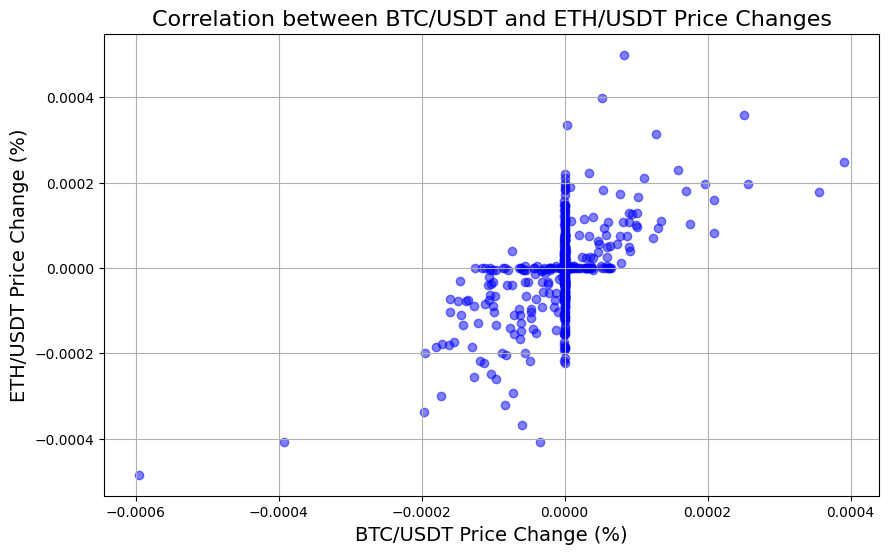

In [130]:
import matplotlib.pyplot as plt
# Extracting the necessary data (BTC/USDT and ETH/USDT price changes)
btc_usdt_price_changes = merged_df['BTC_pct_change']
eth_usdt_price_changes = merged_df['ETH_pct_change']

# Plotting the correlation between BTC/USDT and ETH/USDT
plt.figure(figsize=(10, 6))
plt.scatter(btc_usdt_price_changes, eth_usdt_price_changes, alpha=0.5, color='blue')

# Adding labels and title
plt.title('Correlation between BTC/USDT and ETH/USDT Price Changes', fontsize=16)
plt.xlabel('BTC/USDT Price Change (%)', fontsize=14)
plt.ylabel('ETH/USDT Price Change (%)', fontsize=14)

# Show plot
plt.grid(True)
plt.show()


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.cuda.empty_cache()

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Assuming 'merged_data_short' is a DataFrame with 'BTC_close' and 'ETH_close' columns
data = merged_data[['BTC_close', 'ETH_close']]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


cuda


NameError: name 'merged_data' is not defined

LSTM Model Architecture <br>
sequence_length = 72 [72 hours = 3 days]<br>
hidden_size = 100  [Nodes every layer]<br>
num_layers = 2     [Total Hidden Layer]<br>
epochs = 1000      [Maximum Epochs]<br>
batch_size = 512   [Total Data every parallel computing]<br>
early_stop_patience = 100 [Early Stop]<br>
Using CUDA for GPU Parallel Training<br>
Sceduler for dynamic learing Rate

In [ ]:
sequence_length = 72
hidden_size = 100  
num_layers = 2    
epochs = 5000     
batch_size = 512   
early_stop_patience = epochs/2

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, 0]  # Using only BTC Price as feature
        y = data[i+seq_length, 1]    # ETH Price as target
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(data_scaled, sequence_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the neural network
class ETHPricePredictor(nn.Module):
    def __init__(self):
        super(ETHPricePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)  # Add feature dimension
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initialize hidden state
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initialize cell state
        out, _ = self.lstm(x, (h_0, c_0))
        out = out[:, -1, :]  # Get the last time step output
        out = self.fc(out)
        return out

model = ETHPricePredictor().to(device)

try:
    model.load_state_dict(torch.load('model1.pkl'))
    print("Model loaded successfully")
except FileNotFoundError:
    print("Model file not found, starting training from scratch")

# Define loss function and optimizer
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Added L2 regularization

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=epochs/100, verbose=True)

# Early stopping parameters
min_loss = float('inf')
early_stop_count = 0

# Define your data loader
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Train the model
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        # Gradient clipping
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    
    # Update learning rate based on validation loss
    scheduler.step(avg_epoch_loss)
    
    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.8f}')
        if avg_epoch_loss < min_loss:
            min_loss = avg_epoch_loss
            torch.save(model.state_dict(), 'model1.pkl')
            early_stop_count = 0
            print(f"Model saved with loss {min_loss:.8f}")
        else:
            early_stop_count += 1
            print(f"No improvement, count: {early_stop_count}")

            
    if early_stop_count > early_stop_patience:
        print("Early stopping")
        break

# Evaluate the model in batches to avoid OOM
model.eval()
predictions = []
with torch.no_grad():
    for i in range(0, X_test.size(0), batch_size):
        X_batch = X_test[i:i+batch_size]
        output = model(X_batch)
        predictions.append(output.cpu().numpy())
        
predictions = np.concatenate(predictions).squeeze()
test_loss = criterion(torch.tensor(predictions).to(device), y_test)
print(f'Test Loss: {test_loss.item():.8f}')

# Convert predictions back to original scale
predicted_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((predictions.shape[0], 1)), predictions.reshape(-1, 1)), axis=1)
)[:, 1]
actual_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((y_test.shape[0], 1)), y_test.cpu().numpy().reshape(-1, 1)), axis=1)
)[:, 1]

# Print sample results
for i in range(10):
    print(f'Predicted: {predicted_prices[i]:.2f}, Actual: {actual_prices[i]:.2f}')

# Calculate evaluation metrics
mae = np.mean(np.abs(predicted_prices - actual_prices))
mse = np.mean((predicted_prices - actual_prices)**2)
rmse = np.sqrt(mse)

# Print evaluation metrics
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')

# Store the results in a list for comparison
model_ratings = [mae, mse, rmse]
print(f'Model Ratings: {model_ratings}')


Model loaded successfully
Epoch [1/5000], Loss: 0.00410642
Model saved with loss 0.00410642
Epoch [2/5000], Loss: 0.00412809
No improvement, count: 1
Epoch [3/5000], Loss: 0.00414204
No improvement, count: 2
Epoch [4/5000], Loss: 0.00413070
No improvement, count: 3
Epoch [5/5000], Loss: 0.00413822
No improvement, count: 4
Epoch [6/5000], Loss: 0.00412493
No improvement, count: 5
Epoch [7/5000], Loss: 0.00411139
No improvement, count: 6
Epoch [8/5000], Loss: 0.00412894
No improvement, count: 7
Epoch [9/5000], Loss: 0.00412475
No improvement, count: 8
Epoch [10/5000], Loss: 0.00410810
No improvement, count: 9
Epoch [11/5000], Loss: 0.00412441
No improvement, count: 10
Epoch [12/5000], Loss: 0.00410560
Model saved with loss 0.00410560
Epoch [13/5000], Loss: 0.00412155
No improvement, count: 1
Epoch [14/5000], Loss: 0.00412555
No improvement, count: 2
Epoch [15/5000], Loss: 0.00409786
Model saved with loss 0.00409786
Epoch [16/5000], Loss: 0.00410490
No improvement, count: 1
Epoch [17/5000

In [ ]:
# MAE MSE RMSE
#Results after every 1000 epoch
#[239.53500421147805, 93175.94332930623, 305.2473477842293]
#[238.2700864640117, 92641.1687534937, 304.3701180364027]
#[237.9094453586917, 92422.66688308927, 304.01096507048766]
#[238.00566570856574, 92504.84181269462, 304.14608630178793]
#[237.77919935939042, 92401.8454408978, 303.97671858367346]
#[218.90863496717768, 79917.47007010943, 282.6967811456463]

Predicting 10 data 

In [ ]:
for i in range(10):
    print(f'Predicted: {predicted_prices[i]:.40f}, Actual: {actual_prices[i]:.10f}')

Predicted: 1419.7055840045213699340820312500000000000000, Actual: 1640.1499774897
Predicted: 1419.2854227018356141343247145414352416992188, Actual: 1637.5899612254
Predicted: 1418.8548958110809508070815354585647583007812, Actual: 1632.0800121921
Predicted: 1418.3191511017084849299862980842590332031250, Actual: 1622.8100525826
Predicted: 1417.6124451863765898451674729585647583007812, Actual: 1623.5600667769
Predicted: 1416.8835881513357435323996469378471374511719, Actual: 1621.8399471349
Predicted: 1416.1339999401568547909846529364585876464844, Actual: 1579.8100434136
Predicted: 1414.7009928882121130300220102071762084960938, Actual: 1577.0999391139
Predicted: 1412.9402628600596472097095102071762084960938, Actual: 1540.5500236166
Predicted: 1410.8689911729097730130888521671295166015625, Actual: 1537.9900073522


Full Prediction with graph

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(len(actual_prices))), y=actual_prices,
                         mode='lines', name='Actual ETH Prices'))
fig.add_trace(go.Scatter(x=list(range(len(predicted_prices))), y=predicted_prices,
                         mode='lines', name='Predicted ETH Prices', opacity=0.7))
fig.update_layout(title='ETH Price Prediction',
                   xaxis_title='Time',
                   yaxis_title='Price')
fig.show()